In [1]:
# System
import os
import sys
import tabulate
import time

# Data processing
import numpy as np
import math as m

# Results presentation
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt

# NN related stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# from torch.autograd import Variable

import data
import models
import utils
import correlation


%matplotlib inline

In [2]:
class GlobalArguments():
    
    def __init__(self):
        self.model       = 'VGG16BN'
        self.dataset     = 'CIFAR10'
        self.data_path   = 'Data/'
        self.batch_size  = 128
        self.num_workers = 4
        self.transform   = 'VGG'
        self.use_test    = True
        self.models_path = 'Checkpoints/'
        self.n_models    = 40
args = GlobalArguments()

In [3]:
loaders, num_classes = data.loaders(
    args.dataset,
    args.data_path,
    args.batch_size,
    args.num_workers,
    args.transform,
    args.use_test
)

Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


In [4]:
print(len(loaders['train']))
print(len(loaders['test']))

n_samples_train = 0
for (x, _) in loaders['train']:
    n_samples_train += x.shape[0]

n_samples_test = 0
for (x, _) in loaders['test']:
    n_samples_test += x.shape[0]

print (n_samples_train)
print (n_samples_test)

391
79
50000
10000


In [5]:
architecture = getattr(models, args.model)

In [6]:
# models_list_ind = []
# indicies = np.arange(args.n_models)
# # np.random.shuffle(indicies[1:-1])

# for i in indicies:
#     model = architecture.base(num_classes=num_classes, **architecture.kwargs)
#     checkpoint = torch.load(
#           args.models_path
#         + args.model + '_'
#         + args.dataset + '_'
#         + str(i) + '/checkpoint-200.pt',
#         map_location=torch.device('cpu'))
# #     print (model)
#     model.load_state_dict(checkpoint['model_state'])
#     models_list_ind.append(model)

In [7]:
models_list_fge = []
# indicies = range (690, 1011, 20)
indicies = range (519, 1310, 20)

for i in indicies:
    model = architecture.base(num_classes=num_classes, **architecture.kwargs)
    checkpoint = torch.load('./Checkpoints/FGE_reg_exp/no_reg_1/fge-' + str(i) + '.pt', map_location=torch.device('cpu'))
#     print (model)
    model.load_state_dict(checkpoint['model_state'])
    models_list_fge.append(model)

In [8]:
models_list_fge_2 = []
# indicies = range (690, 1011, 20)
indicies = range (519, 1310, 20)

for i in indicies:
    model = architecture.base(num_classes=num_classes, **architecture.kwargs)
    checkpoint = torch.load('./Checkpoints/FGE_reg_exp/with_reg_1/fge-' + str(i) + '.pt', map_location=torch.device('cpu'))
#     print (model)
    model.load_state_dict(checkpoint['model_state'])
    models_list_fge_2.append(model)

In [9]:
len(models_list_fge)
len(models_list_fge_2)


40

In [10]:
def ensemble_models (model_list, dataloader, device=torch.device('cpu')):
    predictions = []
    target = []
    n_models = len(model_list)
    
    for _, labels in dataloader:
        target.append(labels.detach())
    target = torch.cat(target, dim=0)
    
    for iter, model in tqdm(enumerate(model_list)):
        model.eval().to(device)
        predictions.append([])
        for input, _ in dataloader:
            predictions[iter].append(model(input.detach().to(device)).detach().cpu())
        predictions[iter] = torch.cat(predictions[iter], dim=0)
        
#     print (predictions[0].shape, predictions[0].dtype)
#     print (target.shape, target.dtype)
    
    sum_prediction = torch.zeros_like(predictions[0])
    acc_list = []
    ens_acc_list = []
    for prediction in tqdm(predictions):
        sum_prediction += prediction
        pred_labels     = prediction    .argmax(dim=1)
        ens_pred_labels = sum_prediction.argmax(dim=1)
        
        acc     = torch.eq(pred_labels    , target).sum().item() / len(target)
        ens_acc = torch.eq(ens_pred_labels, target).sum().item() / len(target)
#         print ('Accuracy: ', acc, 'Ensemble accuracy: ', ens_acc)
        acc_list    .append(acc)
        ens_acc_list.append(ens_acc)
        
    return acc_list, ens_acc_list

In [11]:
# cor_matrix = correlation.cross_entropy_Nmodels (needed_models, loaders['test'], torch.device('cpu'))

In [12]:
# acc_list_ind, ens_acc_list_ind = ensemble_models(models_list_ind, loaders['train'], torch.device('cpu'))

In [13]:
acc_list_fge, ens_acc_list_fge = ensemble_models(models_list_fge, loaders['test'], torch.device('cuda:0'))

In [14]:
acc_list_fge_2, ens_acc_list_fge_2 = ensemble_models(models_list_fge_2, loaders['test'], torch.device('cuda:0'))

In [15]:
def plot (y_mas, time, savefig=None):

    fig, ax = plt.subplots()
    for iter, y in enumerate(y_mas):
        ax.plot(time, y, label=str(iter))

    ax.set(xlabel='Number of models', ylabel='Accuracy',
           title='Ensembling methods comparison')
    ax.grid()

    if savefig is not None:
        fig.savefig(savefig)
    plt.legend()
    plt.show()

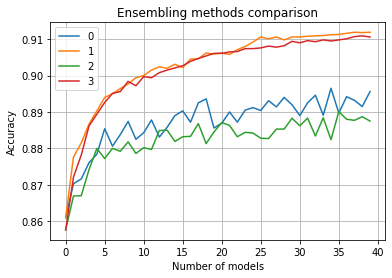

In [16]:
# plot ([acc_list_ind, acc_list_fge, ens_acc_list_ind, ens_acc_list_fge], np.arange(len(acc_list_ind)))
# plot ([acc_list_fge, ens_acc_list_fge], np.arange(len(acc_list_fge)))
plot ([acc_list_fge, ens_acc_list_fge, acc_list_fge_2, ens_acc_list_fge_2], np.arange(len(acc_list_fge)))
